In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from scripts import pyensembl_operations as po
from scripts.pipeline_steps import step5 as s5

# pd show all columns
pd.set_option('display.max_columns', None)

engine = create_engine('sqlite:///data/db/mirscribe.db')


g37 = po.import_pyensembl(37)


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


In [4]:
transcripts = pd.read_sql_table("transcripts", engine)
genes = pd.read_sql_table("genes", engine)
mirnas = pd.read_sql_table("mirnas", engine)

In [3]:
mut_threshold, wt_threshold = (0.5 , 0.5)

df = pd.read_sql_table('predictions', engine)
df.fillna(np.nan, inplace=True)
df = s5.filter_rows_by_thresholds(df, mut_threshold, wt_threshold)

df["gain"] = df.mut_prediction > df.wt_prediction
df["loss"] = df.mut_prediction < df.wt_prediction

df = df.merge(genes[["gene_id", "gene_name", "gene_biotype", "in_cgc", "is_driver"]], on="gene_id", how="left")
df = df.merge(mirnas[["mirna_accession", "mirna_name", "mirna_family",  "seed"]], on="mirna_accession", how="left")

df.head()

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,mutation_context,mutsig,gain,loss,gene_name,gene_biotype,in_cgc,is_driver,mirna_name,mirna_family,seed
0,PD4005a_1_12844091_G_T_MIMAT0000265,0.411319,0.724802,0.313,PD4005a,MIMAT0000265,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,NaN,hsa-miR-204-5p,miR-204-5p/211-5p,GGCATAG
1,PD4005a_1_12844091_G_T_MIMAT0003301,0.289311,0.662916,0.374,PD4005a,MIMAT0003301,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,NaN,hsa-miR-33b-5p,miR-33-5p,CAATGCA
2,PD4005a_1_12844091_G_T_MIMAT0004517,0.351466,0.623310,0.272,PD4005a,MIMAT0004517,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,NaN,hsa-miR-106a-3p,miR-106a-3p,TAAGAAG
3,PD4005a_1_12844091_G_T_MIMAT0005882,0.550857,0.279106,-0.272,PD4005a,MIMAT0005882,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,NaN,hsa-miR-548k,miR-548av-5p/548k/8054,GCAAAAT
4,PD4005a_1_12844091_G_T_MIMAT0005933,0.650570,0.375474,-0.275,PD4005a,MIMAT0005933,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,NaN,hsa-miR-1277-3p,miR-1277-3p,AAATACA


In [4]:
genes

,gene_id,gene_name,chr,start,end,gene_biotype,in_cgc,is_driver
0,ENSG00000279928,DDX11L17,1,182696,184174,unprocessed_pseudogene,False,False
1,ENSG00000228037,None,1,2581560,2584533,lncRNA,False,False
2,ENSG00000142611,PRDM16,1,3069168,3438621,protein_coding,True,False
3,ENSG00000284616,None,1,5301928,5307394,lncRNA,False,False
4,ENSG00000157911,PEX10,1,2403964,2413797,protein_coding,False,False
...,...,...,...,...,...,...,...,...
63236,ENSG00000271254,None,KI270711.1,4612,29626,protein_coding,False,False
63237,ENSG00000275987,U1,KI270713.1,30437,30580,snRNA,False,False
63238,ENSG00000268674,None,KI270713.1,35407,35916,protein_coding,False,False
63239,ENSG00000277475,None,KI270713.1,31698,32528,protein_coding,False,False


# plots

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


# mutsig & seed

Text(0.5, 1.0, 'MutSig distribution across seeds')

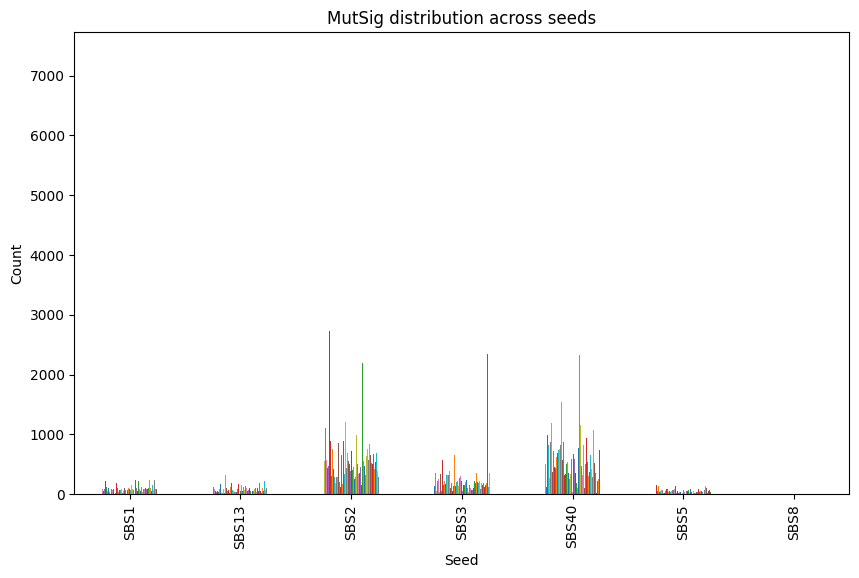

In [5]:
df.groupby(['mutsig', 'seed']).size().unstack().plot(kind='bar', figsize=(10, 6), legend=False)
plt.xlabel('Seed')
plt.ylabel('Count')
plt.title('MutSig distribution across seeds')


In [11]:
df[df.mutsig == "SBS3"].seed.value_counts().sort_values(ascending=False)

seed
CAAAAAC    2428
TGTGGGG    2348
CACTCTA    2252
TGGGGAG    2055
TGGGAGG    1448
           ... 
CTGGGAC       4
CCAGCCC       4
GGCTGCA       4
CGGGTGC       3
GCGGGAC       2
Name: count, Length: 2162, dtype: int64

In [12]:
mirnas

,mirna_name,mirna_accession,sequence,mirna_family,conservation,seed
0,hsa-let-7a-5p,MIMAT0000062,AACTATACAACCTACTACCTCA,let-7-5p/98-5p,2.0,ACTATAC
1,hsa-let-7b-5p,MIMAT0000063,AACCACACAACCTACTACCTCA,let-7-5p/98-5p,2.0,ACCACAC
2,hsa-let-7c-5p,MIMAT0000064,AACCATACAACCTACTACCTCA,let-7-5p/98-5p,2.0,ACCATAC
3,hsa-let-7d-5p,MIMAT0000065,AACTATGCAACCTACTACCTCT,let-7-5p/98-5p,2.0,ACTATGC
4,hsa-let-7e-5p,MIMAT0000066,AACTATACAACCTCCTACCTCA,let-7-5p/98-5p,2.0,ACTATAC
...,...,...,...,...,...,...
2651,hsa-miR-12131,MIMAT0049025,TGGGAGTACACCTCTCCAAA,miR-12131_pred,-1.0,GGGAGTA
2652,hsa-miR-12132,MIMAT0049026,CATCATAATTCTCACAGTAATA,miR-12132_pred,2.0,ATCATAA
2653,hsa-miR-12133,MIMAT0049027,TGTACTTTTTAATGGTGCCAAG,miR-12133_pred,2.0,GTACTTT
2654,hsa-miR-12135,MIMAT0049031,TTTACAAACAAACCTTTA,miR-12135_pred,-1.0,TTACAAA


In [13]:
mutsig_seed_counts = df.groupby(['mutsig', 'seed']).size().reset_index(name='count').sort_values('count', ascending=False)
mutsig_seed_counts

,mutsig,seed,count
10725,SBS40,TGTGGGG,7357
6401,SBS2,TGTGGGG,6748
9239,SBS40,CACTCTA,6625
9125,SBS40,CAAAAAC,6216
4915,SBS2,CACTCTA,6117
...,...,...,...
13175,SBS8,ACGCCAG,1
14640,SBS8,TCCCATG,1
13179,SBS8,ACGTAGT,1
14092,SBS8,GACTGGC,1


In [16]:
mutsig_seed_counts[["mutsig", "count"]].plot(kind="bar", x="mutsig", y="count", figsize=(10, 6))

NameError: name 'mutsig_seed_counts' is not defined

In [10]:
seed_mutsig_freq = df.groupby(['mutsig', 'seed']).size().reset_index(name='count')
seed_mutsig_freq['freq'] = seed_mutsig_freq['count'] / seed_mutsig_freq.groupby('mutsig')['count'].transform('sum')

seed_mutsig_entropy = seed_mutsig_freq.groupby('mutsig')['freq'].apply(lambda x: -np.sum(x * np.log(x))).reset_index(name='entropy')

seed_mutsig_entropy.sort_values('entropy', ascending=False)

# lower values indicate more concentrated seed distribution

,mutsig,entropy
4,SBS40,7.440855
5,SBS5,7.435879
2,SBS2,7.435394
3,SBS3,7.433287
1,SBS13,7.432900
0,SBS1,7.417655
6,SBS8,7.313172


# heatmap

/tmp/ipykernel_6230/3019052911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['gain_loss'] = np.where(driver_df['gain'], 'gain', np.where(driver_df['loss'], 'loss', 'neither'))


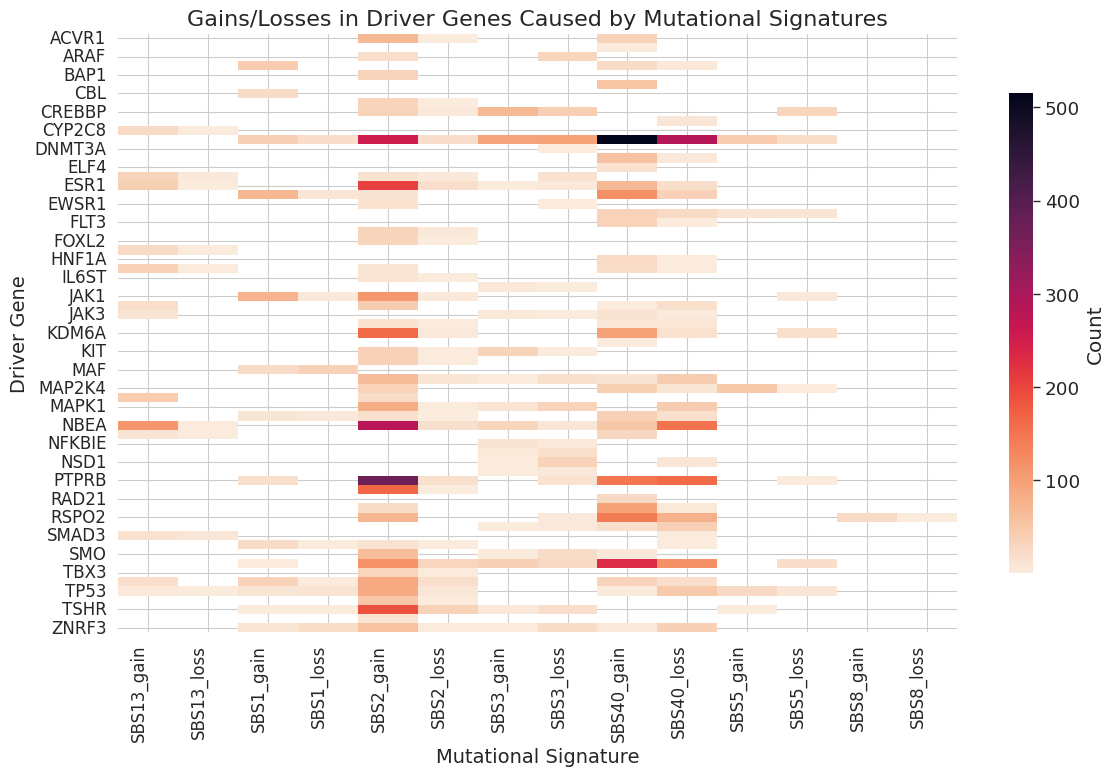

In [17]:
df.is_driver.fillna(False, inplace=True)

# Filter the data to include only known driver genes
driver_df = df[df['is_driver']]

# Create separate columns for gain and loss
driver_df['gain_loss'] = np.where(driver_df['gain'], 'gain', np.where(driver_df['loss'], 'loss', 'neither'))

# Pivot the data to create a matrix of driver gene vs mutsig counts
heatmap_data = pd.crosstab(driver_df['gene_name'], driver_df['mutsig'] + '_' + driver_df['gain_loss'])

# Replace 0s with NaNs for better visualization
heatmap_data = heatmap_data.replace(0, np.nan)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.set_context("paper", font_scale=1.5)  # increase font size for publishing
sns.set_style("whitegrid")  # add gridlines for better readability

sns.heatmap(heatmap_data, cmap='rocket_r', cbar_kws={'label': 'Count', 'shrink': 0.8})  # adjust colorbar size
plt.xlabel('Mutational Signature', fontsize=14)  # increase font size for axis labels
plt.ylabel('Driver Gene', fontsize=14)
plt.title('Gains/Losses in Driver Genes Caused by Mutational Signatures', fontsize=16)  # increase font size for title
plt.xticks( ha='right', fontsize=12)  # increase font size for tick labels
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
heatmap_data.sort_values("SBS40_gain", ascending=False).head()

col_0,SBS13_gain,SBS13_loss,SBS1_gain,SBS1_loss,SBS2_gain,SBS2_loss,SBS3_gain,SBS3_loss,SBS40_gain,SBS40_loss,SBS5_gain,SBS5_loss,SBS8_gain,SBS8_loss
gene_name,,,,,,,,,,,,,,
DCC,NaN,NaN,39.0,18.0,254.0,18.0,95.0,96.0,515.0,287.0,44.0,21.0,NaN,NaN
STAG2,NaN,NaN,3.0,NaN,117.0,31.0,38.0,26.0,230.0,118.0,NaN,18.0,NaN,NaN
PTPRB,NaN,NaN,17.0,NaN,373.0,17.0,NaN,15.0,149.0,161.0,NaN,1.0,NaN,NaN
RSPO2,NaN,NaN,NaN,NaN,72.0,NaN,NaN,5.0,143.0,78.0,NaN,NaN,24.0,1.0
ETV6,NaN,NaN,70.0,9.0,13.0,NaN,NaN,NaN,120.0,36.0,NaN,NaN,NaN,NaN


In [21]:
genes[genes.gene_name == "DCC"]

,gene_id,gene_name,chr,start,end,gene_biotype,in_cgc,is_driver
55494,ENSG00000187323,DCC,18,52340197,53535899,protein_coding,True,True


In [ ]:
gsea = pd.read_csv("data/gsea/")

# Effect of Mutational Signatures on miRNA Families

In [6]:
def generate_heatmap_data(column_name, only_drivers=True):
    # Filter the data to include only rows with gain or loss
    filtered_df = df[(df['gain'] == True) | (df['loss'] == True)]

    # Filter for driver genes if only_drivers is True
    if only_drivers:
        filtered_df = filtered_df[filtered_df['is_driver'] == True]

    # Create a new column 'regulation' based on gain/loss
    filtered_df['regulation'] = filtered_df['gain'].map({True: 'Downregulation', False: 'Upregulation'})

    # Pivot the data to create a matrix of the specified column vs mirna_family with regulation as values
    heatmap_data = pd.crosstab([filtered_df[column_name], filtered_df['mirna_family']], filtered_df['regulation'])

    # Replace NaNs with 0 for better visualization
    heatmap_data = heatmap_data.fillna(0)

    return heatmap_data

generate_heatmap_data("mutsig")

regulation             Downregulation  Upregulation
mutsig mirna_family                                
SBS1   let-7-5p/98-5p               3             0
       miR-1-3p/206                 0             1
       miR-10-5p                    2             1
       miR-103-3p/107               1             0
       miR-10398_pred               0             1
...                               ...           ...
SBS8   miR-631/3661                 1             0
       miR-652-5p                   1             0
       miR-216b-3p                  1             0
       miR-3651                     1             0
       miR-6881-5p                  1             0

[4424 rows x 2 columns]

In [7]:
generate_heatmap_data("mutsig").sort_values(by="Upregulation", ascending=False)


regulation                                                 Downregulation  \
mutsig mirna_family                                                         
SBS40  miR-518a-5p/527                                                  6   
       miR-25-3p/32-5p/92-3p/363-3p/367-3p                              7   
       miR-302-3p/372-3p/373-3p/520-3p                                 14   
       miR-30-5p                                                        6   
SBS2   miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-5...              22   
...                                                                   ...   
       miR-34c-3p                                                       1   
       miR-3529-3p                                                      2   
       miR-3605-3p                                                      2   
       miR-3611                                                         1   
SBS8   miR-6881-5p                                                      1   

regulation                                                 Upregulation  
mutsig mirna_family                                                      
SBS40  miR-518a-5p/527                                                8  
       miR-25-3p/32-5p/92-3p/363-3p/367-3p                            8  
       miR-302-3p/372-3p/373-3p/520-3p                                8  
       miR-30-5p                                                      8  
SBS2   miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-5...             6  
...                                                                 ...  
       miR-34c-3p                                                     0  
       miR-3529-3p                                                    0  
       miR-3605-3p                                                    0  
       miR-3611                                                       0  
SBS8   miR-6881-5p                                                    0  

[4424 rows x 2 columns]

In [24]:
df

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,mutation_context,mutsig,gain,loss,gene_name,gene_biotype,in_cgc,is_driver,mirna_name,mirna_family,seed
0,PD4005a_1_12844091_G_T_MIMAT0000265,0.411319,0.724802,0.313,PD4005a,MIMAT0000265,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-204-5p,miR-204-5p/211-5p,GGCATAG
1,PD4005a_1_12844091_G_T_MIMAT0003301,0.289311,0.662916,0.374,PD4005a,MIMAT0003301,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-33b-5p,miR-33-5p,CAATGCA
2,PD4005a_1_12844091_G_T_MIMAT0004517,0.351466,0.623310,0.272,PD4005a,MIMAT0004517,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-106a-3p,miR-106a-3p,TAAGAAG
3,PD4005a_1_12844091_G_T_MIMAT0005882,0.550857,0.279106,-0.272,PD4005a,MIMAT0005882,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,False,hsa-miR-548k,miR-548av-5p/548k/8054,GCAAAAT
4,PD4005a_1_12844091_G_T_MIMAT0005933,0.650570,0.375474,-0.275,PD4005a,MIMAT0005933,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,False,hsa-miR-1277-3p,miR-1277-3p,AAATACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608884,PD3890a_3_9912562_G_T_MIMAT0027509,0.437611,0.875881,0.438,PD3890a,MIMAT0027509,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6804-3p,miR-6804-3p,TGTGGGT
3608885,PD3890a_3_9912562_G_T_MIMAT0027535,0.305159,0.604791,0.300,PD3890a,MIMAT0027535,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6817-3p,miR-6817-3p,GCCATGG
3608886,PD3890a_3_9912562_G_T_MIMAT0027581,0.402005,0.725282,0.323,PD3890a,MIMAT0027581,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6839-3p,miR-6839-3p,TGGATTG
3608887,PD3890a_3_9912562_G_T_MIMAT0027627,0.247087,0.528400,0.281,PD3890a,MIMAT0027627,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6863,miR-6863,ACTCAAT


In [29]:
genes.is_driver.value_counts()

is_driver
False    63154
True        87
Name: count, dtype: int64

In [ ]:
import sqlalchemy

engine = sqlalchemy.create_engine("sqlite:///data/mirna.db")

In [30]:
genes

,gene_id,gene_name,chr,start,end,gene_biotype,in_cgc,is_driver
0,ENSG00000279928,DDX11L17,1,182696,184174,unprocessed_pseudogene,False,False
1,ENSG00000228037,None,1,2581560,2584533,lncRNA,False,False
2,ENSG00000142611,PRDM16,1,3069168,3438621,protein_coding,True,False
3,ENSG00000284616,None,1,5301928,5307394,lncRNA,False,False
4,ENSG00000157911,PEX10,1,2403964,2413797,protein_coding,False,False
...,...,...,...,...,...,...,...,...
63236,ENSG00000271254,None,KI270711.1,4612,29626,protein_coding,False,False
63237,ENSG00000275987,U1,KI270713.1,30437,30580,snRNA,False,False
63238,ENSG00000268674,None,KI270713.1,35407,35916,protein_coding,False,False
63239,ENSG00000277475,None,KI270713.1,31698,32528,protein_coding,False,False


In [27]:
len(genes.is_driver)

63241

In [25]:
df[(df.gene_name == "DCC") & (df.mutsig == "SBS2")].mutation_context.value_counts()

mutation_context
T[C>T]A    220
T[C>T]T     52
Name: count, dtype: int64

In [ ]:
df[df]

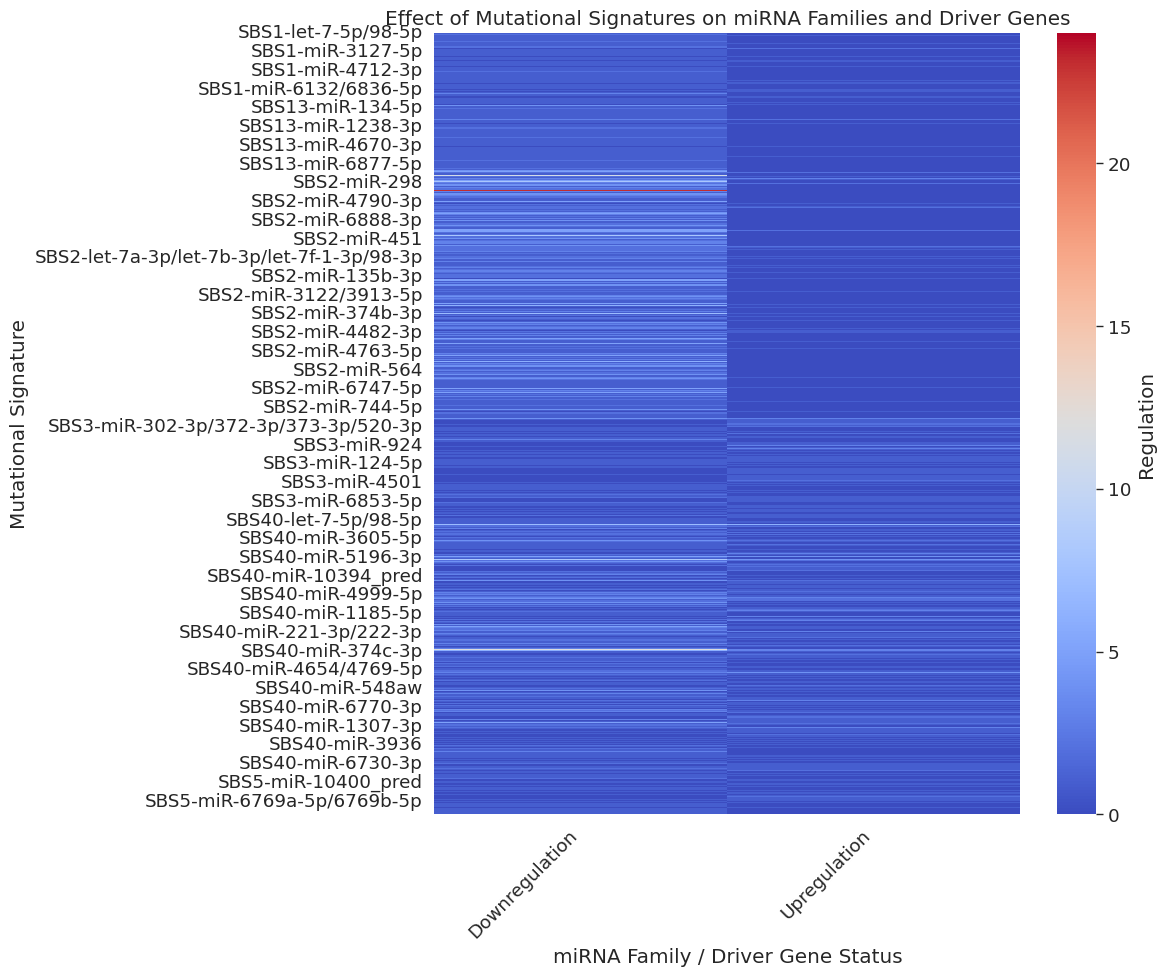

In [44]:
filtered_df = df[(df['gain'] == True) | (df['loss'] == True)]
filtered_df = filtered_df[filtered_df['is_driver'] == True]

# Create a new column 'regulation' based on gain/loss
filtered_df['regulation'] = filtered_df['gain'].map({True: 'Downregulation', False: 'Upregulation'})

# Pivot the data to create a matrix of mutsig vs mirna_family with regulation as values
heatmap_data = pd.crosstab([filtered_df['mutsig'], filtered_df['mirna_family']], filtered_df['regulation'])

# Replace NaNs with 0 for better visualization
heatmap_data = heatmap_data.fillna(0)


# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Regulation'}, annot=False, fmt='d')
plt.xlabel('miRNA Family / Driver Gene Status')
plt.ylabel('Mutational Signature')
plt.title('Effect of Mutational Signatures on miRNA Families and Driver Genes')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [50]:
df[(df.mutsig == "SBS2") & (df.is_driver) & (df.mirna_family == "let-7-5p/98-5p")].gene_name.value_counts()

gene_name
ACVR1    5
PTPRB    4
NBEA     3
ESR1     3
DCC      2
TP53     2
TSHR     1
IL6ST    1
KDM6A    1
ARAF     1
TSC1     1
Name: count, dtype: int64

# Effect of Mutation Contexts on miRNA Families Targeting Driver Genes

In [56]:
generate_heatmap_data("mutation_context")


regulation                                             Downregulation  \
mutation_context mirna_family                                           
A[C>A]A          miR-1-3p/206                                       1   
                 miR-10-5p                                          1   
                 miR-101_pred                                       1   
                 miR-10399_pred                                     1   
                 miR-15-5p/16-5p/195-5p/424-5p/497-5p               1   
...                                                               ...   
T[T>G]T          miR-8057                                           0   
                 miR-8074                                           0   
                 miR-891a-5p                                        0   
                 miR-95-5p                                          0   
                 miR-96-5p/1271-5p                                  0   

regulation                                             Upregulation  
mutation_context mirna_family                                        
A[C>A]A          miR-1-3p/206                                     0  
                 miR-10-5p                                        0  
                 miR-101_pred                                     0  
                 miR-10399_pred                                   0  
                 miR-15-5p/16-5p/195-5p/424-5p/497-5p             0  
...                                                             ...  
T[T>G]T          miR-8057                                         1  
                 miR-8074                                         1  
                 miR-891a-5p                                      1  
                 miR-95-5p                                        1  
                 miR-96-5p/1271-5p                                1  

[6999 rows x 2 columns]

In [58]:
generate_heatmap_data("seed").sort_values("Upregulation", ascending=False)


,regulation,Downregulation,Upregulation
seed,mirna_family,,
AAAAACT,miR-548aj-5p/548f-5p/548g-5p/548x-5p,12,9
AACCAAT,miR-199-3p,11,9
CAAAAAC,miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-5p/548ap-5p/548am-5p/548ae-5p/548ad-5p/548a-5p/548ak/548ab/548bb-5p/548b-5p/548c-5p/548d-5p/548h-5p/548i/548j-5p/548o-5p/548w/548y/559,9,9
AAAGGGC,miR-518a-5p/527,16,8
TTCCAGT,miR-30-5p,18,8
...,...,...,...
GCCGGTC,miR-1307-5p,2,0
CACCCCA,miR-6793-5p,1,0
CACCCAG,miR-1295a,5,0


In [60]:
# Filter the data to include only driver genes
driver_df = df[df['is_driver'] == True]

# Group by mutation family, driver gene, and mutsig
grouped_data = driver_df.groupby(['mirna_family', 'gene_name', 'mutsig']).size().reset_index(name='count')

# Pivot the data to create a matrix of mutation family vs driver gene with mutsig as values
pivot_data = grouped_data.pivot_table(index='mirna_family', columns='gene_name', values='mutsig', aggfunc=lambda x: ', '.join(x)).T

# Fill NaNs with an empty string for better readability
pivot_data = pivot_data.fillna('')

pivot_data

mirna_family let-7-5p/98-5p let-7a-2-3p/let-7g-3p  \
gene_name                                           
ACVR1                  SBS2                         
ACVR2A                                              
ARAF                   SBS2                         
ASXL2           SBS1, SBS40                         
BAP1                                                
...                     ...                   ...   
TP53                   SBS2                         
TSC1                   SBS2                         
TSHR             SBS2, SBS3                         
XPO1                                                
ZNRF3                 SBS40                         

mirna_family let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p let-7c-3p let-7d-3p  \
gene_name                                                                
ACVR1                                                   SBS2             
ACVR2A                                                                   
ARAF                                                                     
ASXL2                                                                    
BAP1                                                                     
...                                            ...       ...       ...   
TP53                                                                     
TSC1                                                                     
TSHR                                                                     
XPO1                                                                     
ZNRF3                                                             SBS3   

mirna_family let-7e-3p let-7f-2-3p/1185-3p let-7i-3p miR-1-3p/206 miR-1-5p  \
gene_name                                                                    
ACVR1                                                                        
ACVR2A                                                                       
ARAF                                                                         
ASXL2                                                                        
BAP1                                                                         
...                ...                 ...       ...          ...      ...   
TP53                                                                         
TSC1                                                                         
TSHR                                                         SBS2            
XPO1                                                                         
ZNRF3                                                                        

mirna_family miR-10-5p miR-100-3p miR-101-5p miR-101_pred miR-10226_pred  \
gene_name                                                                  
ACVR1                                                                      
ACVR2A                                                                     
ARAF              SBS3                                                     
ASXL2             SBS1                                                     
BAP1                                                                       
...                ...        ...        ...          ...            ...   
TP53                                                                       
TSC1              SBS2                                                     
TSHR                                                                       
XPO1              SBS2                                                     
ZNRF3                                                                      

mirna_family miR-103-3p/107 miR-10392_pred miR-10393_pred miR-10394_pred  \
gene_name                                                                  
ACVR1                                                                      
ACVR2A                                                                     
ARAF                                   

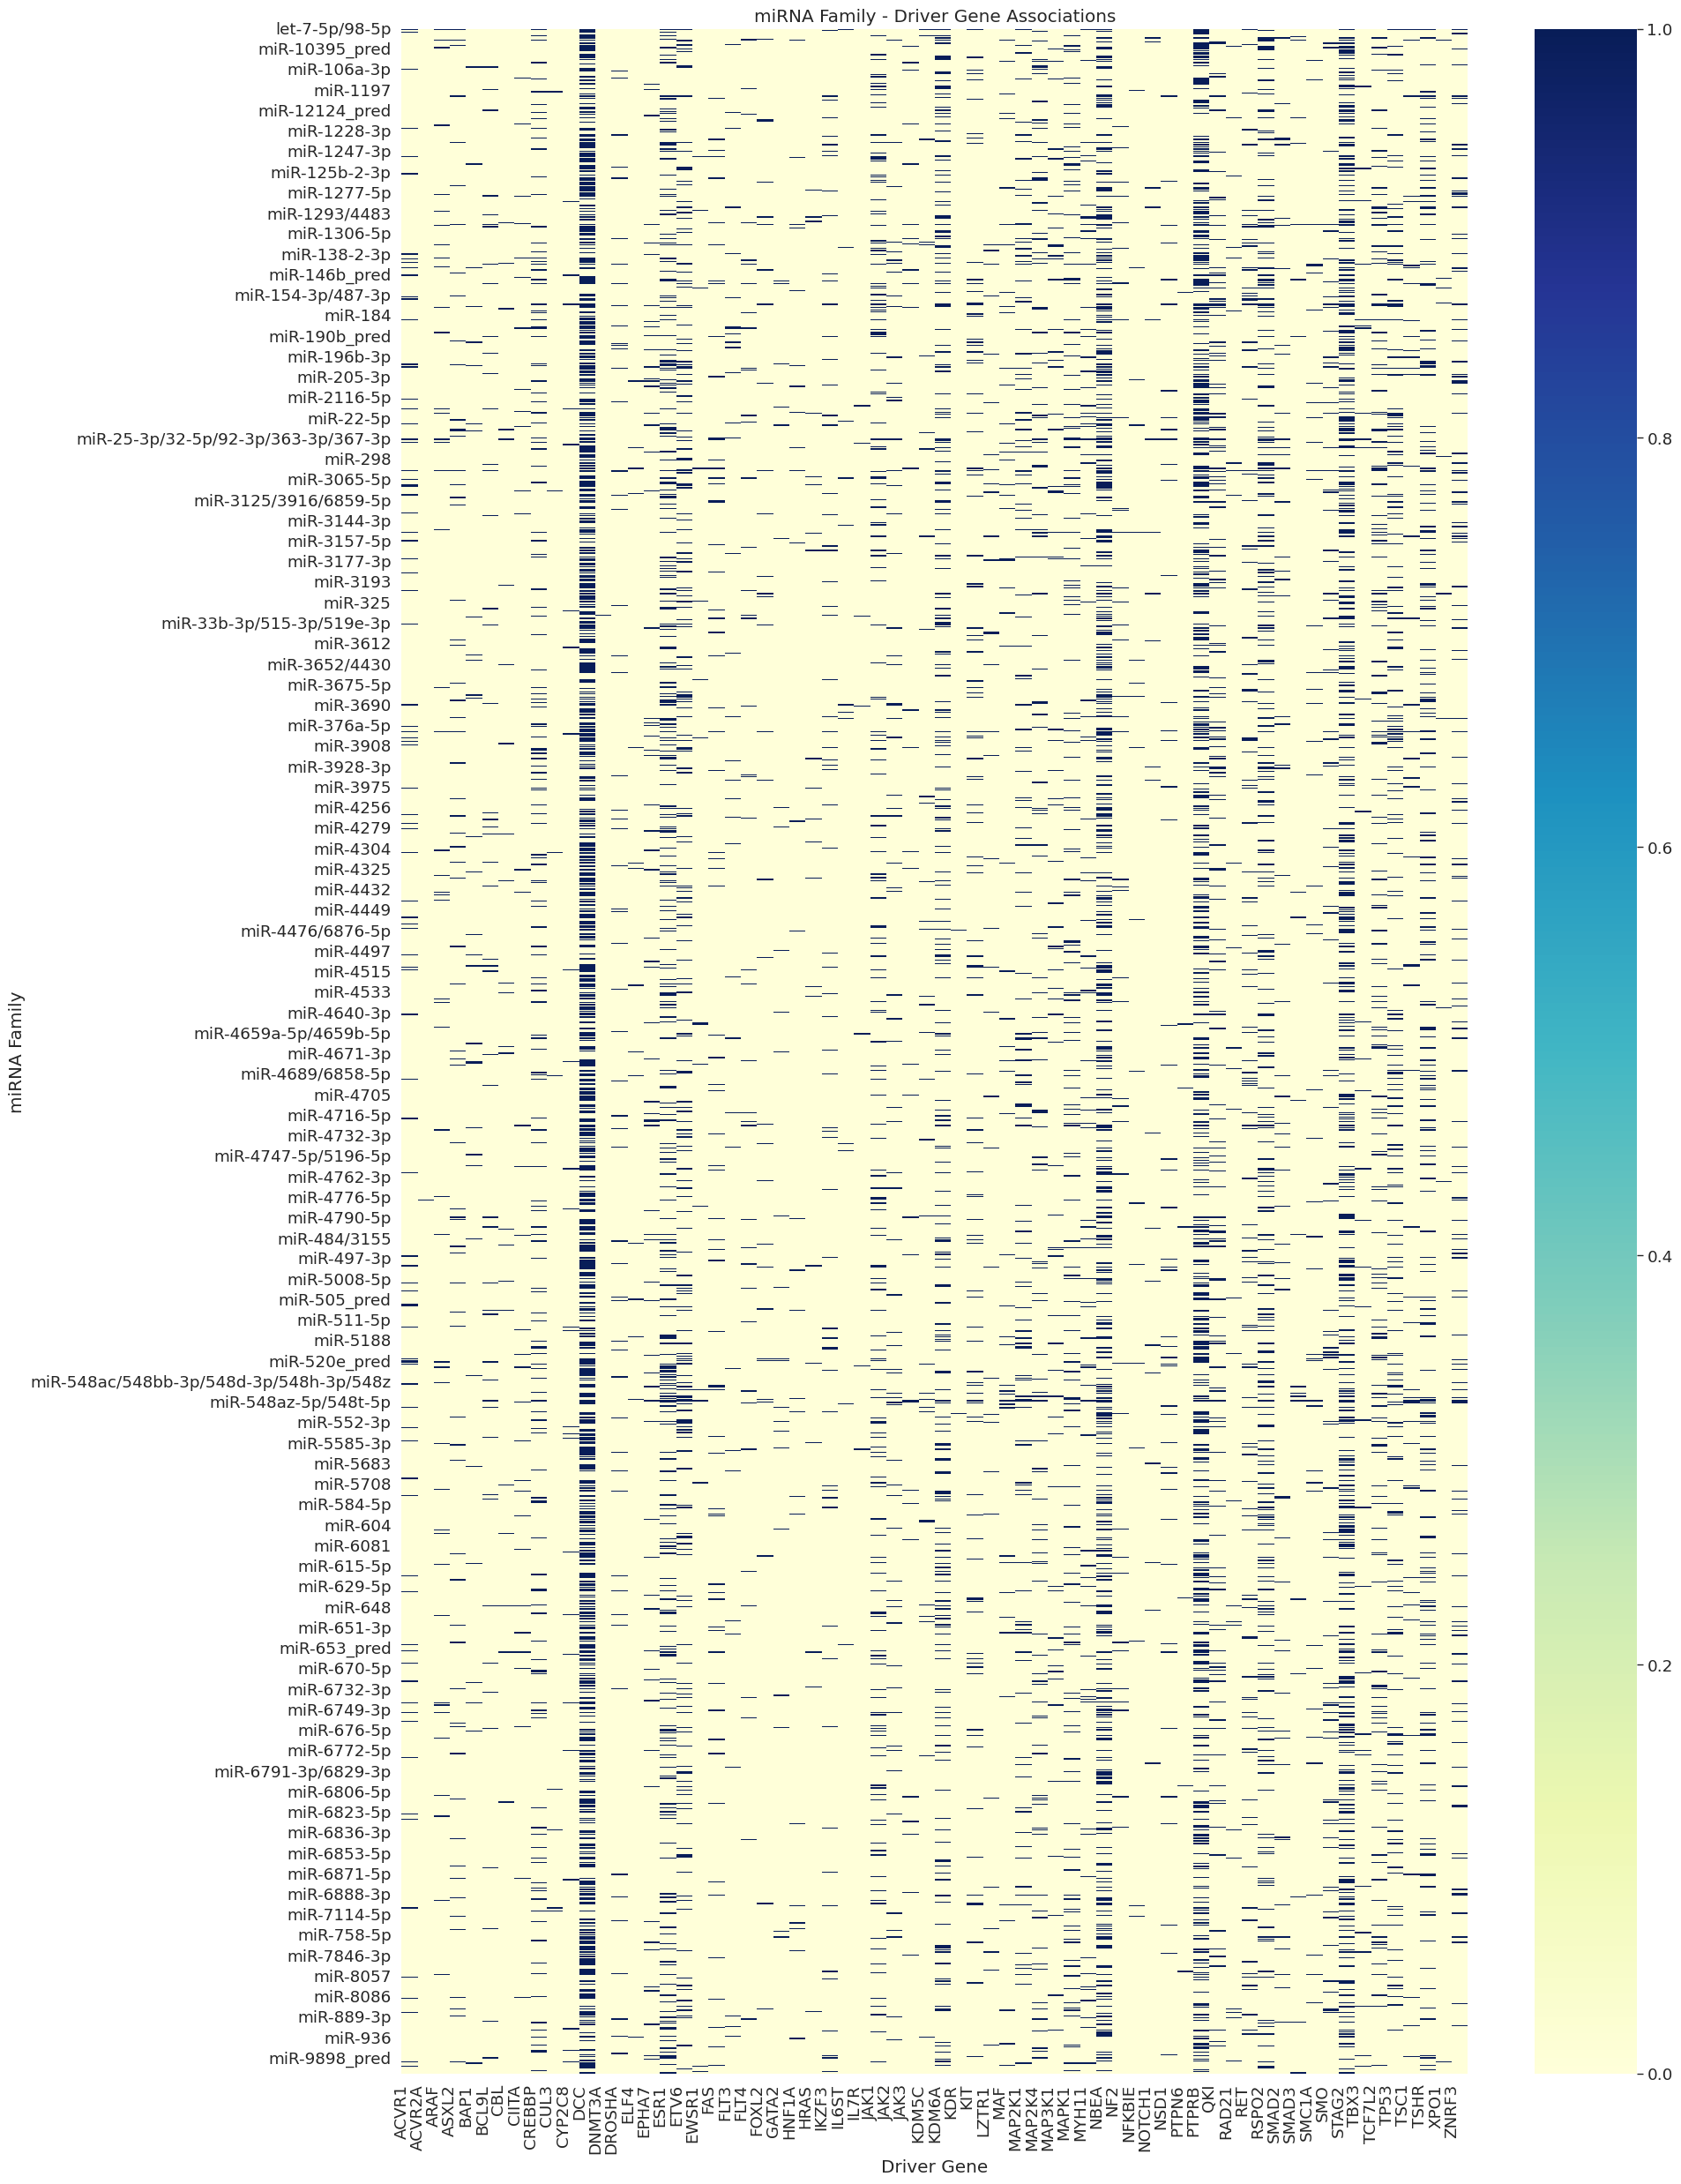

In [82]:
driver_df = df[df['is_driver'] == True]

# Group by mutation family, driver gene, and mutsig
grouped_data = driver_df.groupby(['mirna_family', 'gene_name']).size().reset_index(name='count')

# Pivot the data to create a matrix of mutation family vs driver gene with binary values
associations_data = grouped_data.pivot_table(index='mirna_family', columns='gene_name', values='count', aggfunc=lambda x: 1)

# Fill NaNs with 0 for better readability
associations_data = associations_data.fillna(0)



fig, ax = plt.subplots(figsize=(20, 25))

# Create a heatmap using seaborn
sns.heatmap(associations_data, annot=False, cmap='YlGnBu', ax=ax)

# Set the plot title and labels
ax.set_title("miRNA Family - Driver Gene Associations")
ax.set_xlabel("Driver Gene")
ax.set_ylabel("miRNA Family")

# Rotate x-axis labels for better readability
plt.xticks(ha='right')

# Adjust the plot layout
plt.tight_layout()

# Display the plot
plt.show()



In [89]:
driver_genes = df[df['is_driver']]

mutsig_driver_genes = driver_genes.groupby(['mutsig', 'gene_name'])['is_driver'].count().reset_index()
mutsig_driver_genes.columns = ['mutsig', 'gene_name', 'count']
mutsig_driver_genes.sort_values(by='count', ascending=False)

,mutsig,gene_name,count
96,SBS40,DCC,802
53,SBS2,PTPRB,390
125,SBS40,STAG2,348
117,SBS40,PTPRB,310
52,SBS2,NBEA,299
...,...,...,...
123,SBS40,SMC1A,1
92,SBS40,ACVR2A,1
122,SBS40,SMAD3,1
73,SBS3,EWSR1,1


In [33]:
df

,id,wt_prediction,mut_prediction,pred_difference,vcf_id,mirna_accession,gene_id,mutation_context,mutsig,gain,loss,gene_name,gene_biotype,in_cgc,is_driver,mirna_name,mirna_family,seed
0,PD4005a_1_12844091_G_T_MIMAT0000265,0.411319,0.724802,0.313,PD4005a,MIMAT0000265,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-204-5p,miR-204-5p/211-5p,GGCATAG
1,PD4005a_1_12844091_G_T_MIMAT0003301,0.289311,0.662916,0.374,PD4005a,MIMAT0003301,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-33b-5p,miR-33-5p,CAATGCA
2,PD4005a_1_12844091_G_T_MIMAT0004517,0.351466,0.623310,0.272,PD4005a,MIMAT0004517,NaN,A[C>A]A,SBS3,True,False,NaN,NaN,NaN,False,hsa-miR-106a-3p,miR-106a-3p,TAAGAAG
3,PD4005a_1_12844091_G_T_MIMAT0005882,0.550857,0.279106,-0.272,PD4005a,MIMAT0005882,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,False,hsa-miR-548k,miR-548av-5p/548k/8054,GCAAAAT
4,PD4005a_1_12844091_G_T_MIMAT0005933,0.650570,0.375474,-0.275,PD4005a,MIMAT0005933,NaN,A[C>A]A,SBS3,False,True,NaN,NaN,NaN,False,hsa-miR-1277-3p,miR-1277-3p,AAATACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608884,PD3890a_3_9912562_G_T_MIMAT0027509,0.437611,0.875881,0.438,PD3890a,MIMAT0027509,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6804-3p,miR-6804-3p,TGTGGGT
3608885,PD3890a_3_9912562_G_T_MIMAT0027535,0.305159,0.604791,0.300,PD3890a,MIMAT0027535,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6817-3p,miR-6817-3p,GCCATGG
3608886,PD3890a_3_9912562_G_T_MIMAT0027581,0.402005,0.725282,0.323,PD3890a,MIMAT0027581,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6839-3p,miR-6839-3p,TGGATTG
3608887,PD3890a_3_9912562_G_T_MIMAT0027627,0.247087,0.528400,0.281,PD3890a,MIMAT0027627,ENSG00000187288,T[C>A]C,SBS3,True,False,CIDEC,protein_coding,False,False,hsa-miR-6863,miR-6863,ACTCAAT


<Axes: ylabel='Frequency'>

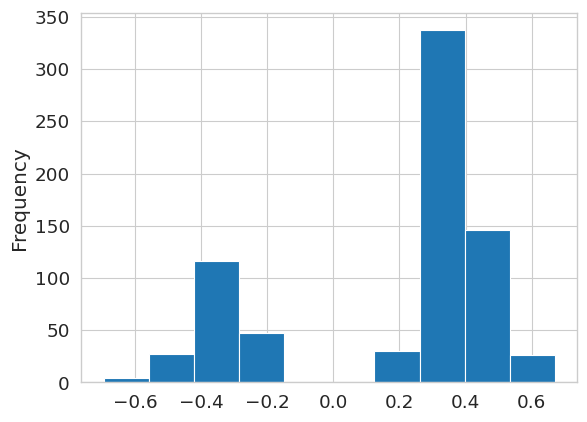

In [43]:
df[(df.gene_name == "PTPRB") ].pred_difference.sort_values(ascending=False).plot(kind='hist')

In [47]:
df[(df.gene_name == "PTPRB") &( df.gain)].mutsig.value_counts()

mutsig
SBS2     373
SBS40    149
SBS1      17
Name: count, dtype: int64

In [81]:
# Count the number of associations for each driver gene
driver_gene_counts = associations_data.sum(axis=0)

driver_gene_counts.sort_values(ascending=False)

gene_name
DCC       952.0
PTPRB     563.0
NBEA      515.0
STAG2     514.0
ESR1      320.0
          ...  
PTPN6       7.0
IL7R        7.0
KDR         2.0
ACVR2A      1.0
DNMT3A      1.0
Length: 66, dtype: float64

In [90]:
driver_genes = df[df['is_driver']]

mutsig_mirna_counts = driver_genes.groupby(['mutsig', 'mirna_family']).size().reset_index(name='count')

mutsig_mirna_counts = mutsig_mirna_counts.sort_values(by='count', ascending=False)

print("\nTop mutsig-mirna_family combinations affecting driver genes:")
print(mutsig_mirna_counts.head())


Top mutsig-mirna_family combinations affecting driver genes:
     mutsig                                       mirna_family  count
1735   SBS2  miR-548ay-5p/548au-5p/548as-5p/548ar-5p/548aq-...     28
770    SBS2                                     let-7-5p/98-5p     24
1274   SBS2                                         miR-378-3p     23
3073  SBS40                    miR-302-3p/372-3p/373-3p/520-3p     22
2756  SBS40                                     let-7-5p/98-5p     18


In [97]:
# Filter for driver genes and mutations with gain or loss
driver_mutations = df[(df['is_driver'])]
# Group by mutsig, gene_name, mirna_family, and gain/loss
grouped = driver_mutations.groupby(['mutsig', 'gene_name', 'mirna_family', 'gain', 'loss'])

# Aggregate counts
mutation_family_counts = grouped.size().reset_index(name='count')

# Add gain and loss columns
mutation_family_counts['gain_count'] = mutation_family_counts.apply(lambda x: x['count'] if x['gain'] else 0, axis=1)
mutation_family_counts['loss_count'] = mutation_family_counts.apply(lambda x: x['count'] if x['loss'] else 0, axis=1)

# Drop gain and loss columns
mutation_family_counts = mutation_family_counts.drop(['gain', 'loss'], axis=1)

# Sort by count in descending order
mutation_family_counts = mutation_family_counts.sort_values('count', ascending=False)

mutation_family_counts =mutation_family_counts.assign(magnitude=lambda x: x['gain_count']-x['loss_count'])

mutation_family_counts

,mutsig,gene_name,mirna_family,count,gain_count,loss_count,magnitude
2476,SBS2,NBEA,miR-548aj-5p/548f-5p/548g-5p/548x-5p,6,6,0,6
2687,SBS2,PTPRB,miR-3689a-5p/3689b-5p/3689e/3689f,6,6,0,6
5031,SBS40,DCC,miR-378-3p,5,5,0,5
885,SBS2,ACVR1,let-7-5p/98-5p,5,5,0,5
5776,SBS40,FAS,miR-30-5p,4,0,4,-4
...,...,...,...,...,...,...,...
2688,SBS2,PTPRB,miR-3692-3p,1,1,0,1
2686,SBS2,PTPRB,miR-3685,1,1,0,1
2685,SBS2,PTPRB,miR-3667-5p,1,1,0,1
2684,SBS2,PTPRB,miR-3664-3p,1,1,0,1


<Axes: ylabel='Frequency'>

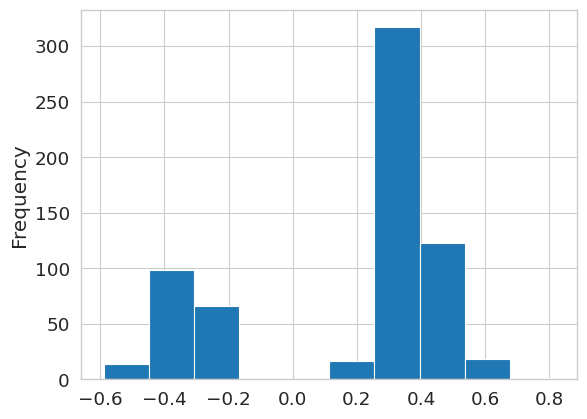

In [48]:
df[(df.gene_name == "NBEA") ].pred_difference.sort_values(ascending=False).plot(kind='hist')


In [99]:
mirna_family_driver_gene_mutsig = (
    driver_genes.groupby(['mirna_family', 'gene_name', 'mutsig'])
    .agg({'wt_prediction': 'mean', 'mut_prediction': 'mean', 'pred_difference': 'mean'})
    .reset_index()
)

mirna_family_driver_gene_mutsig.sort_values(by='pred_difference', ascending=False)

,mirna_family,gene_name,mutsig,wt_prediction,mut_prediction,pred_difference
614,miR-126_pred,NBEA,SBS2,0.139597,0.956165,0.817
3627,miR-4436b-3p/4632-5p/6735-5p/6879-5p/7843-5p,JAK1,SBS1,0.145004,0.951280,0.806
2550,miR-33-5p,BCL9L,SBS40,0.171742,0.931044,0.759
932,miR-140-5p,RAD21,SBS40,0.066844,0.822524,0.756
2861,miR-3688-3p,TSHR,SBS2,0.042081,0.796134,0.754
...,...,...,...,...,...,...
3847,miR-450a-2-3p,STAG2,SBS40,0.815983,0.201181,-0.615
981,miR-143-3p,MAPK1,SBS40,0.841146,0.219716,-0.621
7678,miR-99-5p/100-5p,JAK1,SBS5,0.938817,0.304192,-0.635
2439,miR-3194-5p,PTPRB,SBS40,0.810820,0.117025,-0.694


In [101]:


# Filter the DataFrame to include only driver genes
driver_df = df[df['is_driver'] == True]

# Create a new DataFrame with the required columns
agg_df = driver_df[['mirna_family', 'gene_name', 'mutsig']]

# Group by miRNA family, gene name, and mutational signature, and count the occurrences
agg_df = agg_df.groupby(['mirna_family', 'gene_name', 'mutsig']).size().reset_index(name='count')

# Pivot the DataFrame to have miRNA families as rows, gene names as columns, and mutational signatures as values
pivot_df = agg_df.pivot_table(index='mirna_family', columns='gene_name', values='mutsig', aggfunc=lambda x: ', '.join(x))

# Fill NaN values with an empty string
pivot_df = pivot_df.fillna('')

# Display the resulting DataFrame
pivot_df


gene_name,ACVR1,ACVR2A,ARAF,ASXL2,BAP1,BCL9L,CBL,CIITA,CREBBP,CUL3,CYP2C8,DCC,DNMT3A,DROSHA,ELF4,EPHA7,ESR1,ETV6,EWSR1,FAS,FLT3,FLT4,FOXL2,GATA2,HNF1A,IKZF3,IL6ST,IL7R,JAK1,JAK2,JAK3,KDM5C,KDM6A,KDR,KIT,LZTR1,MAF,MAP2K1,MAP2K4,MAP3K1,MAPK1,MYH11,NBEA,NF2,NFKBIE,NOTCH1,NSD1,PTPN6,PTPRB,QKI,RAD21,RET,RSPO2,SMAD2,SMAD3,SMC1A,SMO,STAG2,TBX3,TCF7L2,TP53,TSC1,TSHR,XPO1,ZNRF3
mirna_family,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
let-7-5p/98-5p,SBS2,,SBS2,"SBS1, SBS40",,,,,SBS3,,,"SBS1, SBS2, SBS40",,,,,"SBS13, SBS2",SBS40,,,,,,,,,SBS2,,,,,SBS40,SBS2,,SBS3,,,SBS40,,,,SBS40,"SBS13, SBS2, SBS3, SBS40",,,,,,"SBS2, SBS40",,,SBS40,,,,,,SBS3,,,SBS2,SBS2,"SBS2, SBS3",,SBS40
let-7a-2-3p/let-7g-3p,,,,,,,,,,,,"SBS40, SBS5",,,,,,,,,,,,,,SBS40,,,,,,,,,,,,,,,,,,,,,,,SBS40,,,,SBS2,,,,,,,,,,,,
let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p,,,,,,,,,,,,SBS2,,,,,,,,,,,,,,,,,,,,,,,,,,,SBS40,,,,SBS2,,,,,,SBS40,,,,,,,,,,,,,,,,
let-7c-3p,SBS2,,,,,,,,,,,"SBS2, SBS40",,,,,SBS2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"SBS2, SBS40",,,,,,,,,,,,,,,,
let-7d-3p,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,SBS2,,,,,,,,,,,,,,,,SBS3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mir-1193_mircarta,,,,,,,,,,,,,,,,,,SBS40,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,SBS40,,,,,,,
mir-154_mircarta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,SBS2,,,,,,,,,,,,,,SBS3,,
mir-544_mircarta,,,,,,,,,SBS3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,SBS2,,SBS2,,,,,,,,,,,,,,,,,,,,,,
